# Exploring Dataset

In [38]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.fft as fft
import seaborn as sns
sns.set()
from tqdm.notebook import tqdm

import sys
sys.path.append("/home/evangelos/workspace/Channel_Charting/")
from tools import utils
from src.models import supervised_classifier, supervised_regressor
from src.utils.data_preparation import SupervisedDataset

from sklearn.decomposition import PCA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def preprocessing(data, first_data, rx_positions, padding=True):
    data = utils.drop_top_right(data, rx_positions)
    data = utils.standarize(data)
    data = utils.fillna(data)
    if padding:
        data = utils.zero_padding_as(data, first_data)
    #data = utils.take_norm(data)
    
    return data

In [3]:
# load datasets
(raw_taps, raw_phi, raw_theta, raw_rx_positions, raw_tx_positions) = utils.load_datasets()
#fourier transform and undersample taps
raw_freq_taps = fft.fft(raw_taps , workers=-1)[:,:,::2]

In [102]:
def reduce_to_mean_std(x):
    return np.stack([np.mean(x,axis=1), 
                          np.std(x,axis=1)], axis=1)

In [103]:
raw_phi_reduced = reduce_to_mean_std(np.cos(raw_phi)**2)

In [104]:
raw_taps_reduced = reduce_to_mean_std(raw_freq_taps)

/home/evangelos/.cache/pypoetry/virtualenvs/channel-charting-8NuP_Ebk-py3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


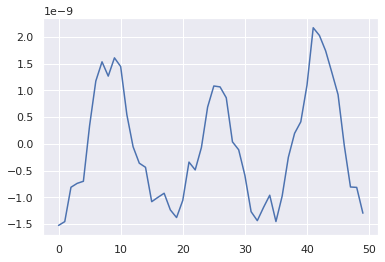

In [105]:
plt.plot(raw_taps_reduced[0][0])

In [62]:
raw_phi_sample_reduced = np.stack([np.mean(np.cos(raw_phi_sample)**2,axis=0), 
                          np.std(np.cos(raw_phi_sample)**2,axis=0)])

In [63]:
raw_phi_sample_reduced.shape

(2, 40)

## Calculate Distance From Example
Here we calculate euclidean distance from our example both in the frequency space and in the real space. 

### Euclidean Distance

In [46]:
freq_distance_from_example = np.array([euclidean_distance(example_signal_1,x) for x in data_fft_scaled])
phi_distance_from_example = np.array([euclidean_distance(example_phi_1,x) for x in phi_scaled])
theta_distance_from_example = np.array([euclidean_distance(example_theta_1,x) for x in theta_scaled])
real_distance = np.array([euclidean_distance(example_pos, pos) for pos in positions_rx_undersample])
distance_from_transmitter = np.array([euclidean_distance(tx_positions[0,:2], pos) for pos in positions_rx_undersample])

In [47]:
#mask = np.isnan(phi_distance_from_example)
#freq_distance_from_example = freq_distance_from_example[~mask]
#real_distance = real_distance[~mask]
#distance_from_transmitter = distance_from_transmitter[~mask]

In [48]:
# Make them similar scale
freq_distance_from_example = standarize(freq_distance_from_example)
real_distance = standarize(real_distance)
distance_from_transmitter = standarize(distance_from_transmitter)

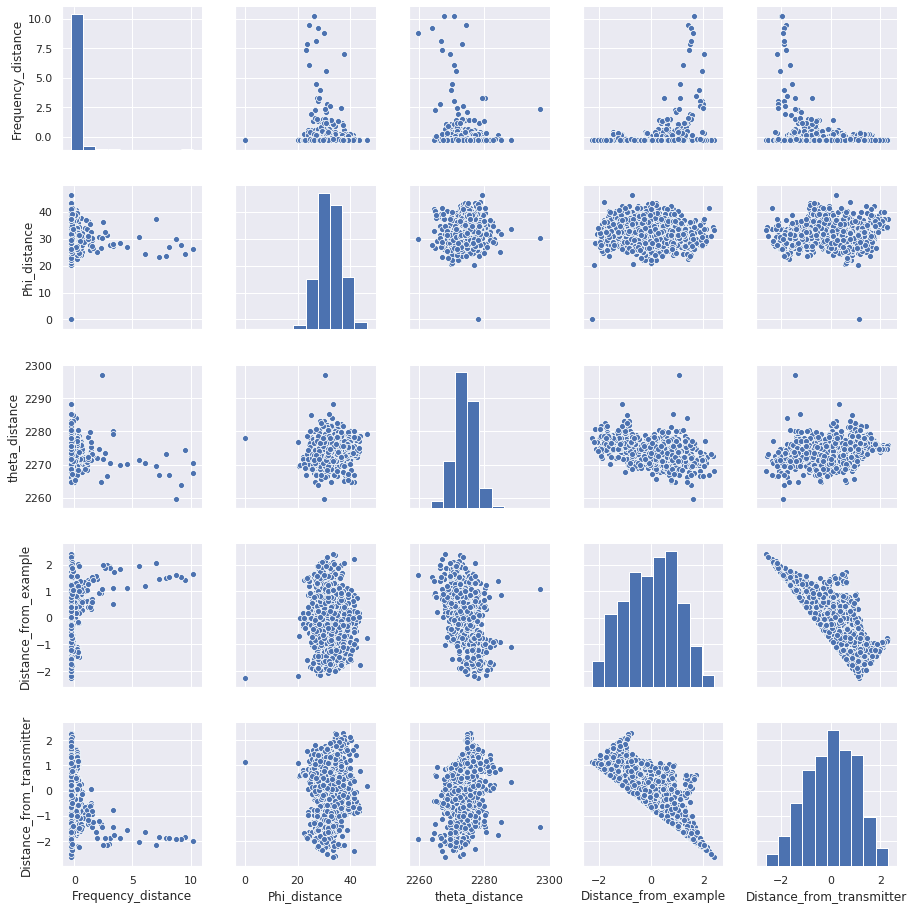

In [49]:
df = pd.DataFrame()
df['Frequency_distance'] = freq_distance_from_example
df['Phi_distance'] = phi_distance_from_example
df['theta_distance'] = theta_distance_from_example
df['Distance_from_example'] = real_distance
df['Distance_from_transmitter'] = distance_from_transmitter
sns.pairplot(df)

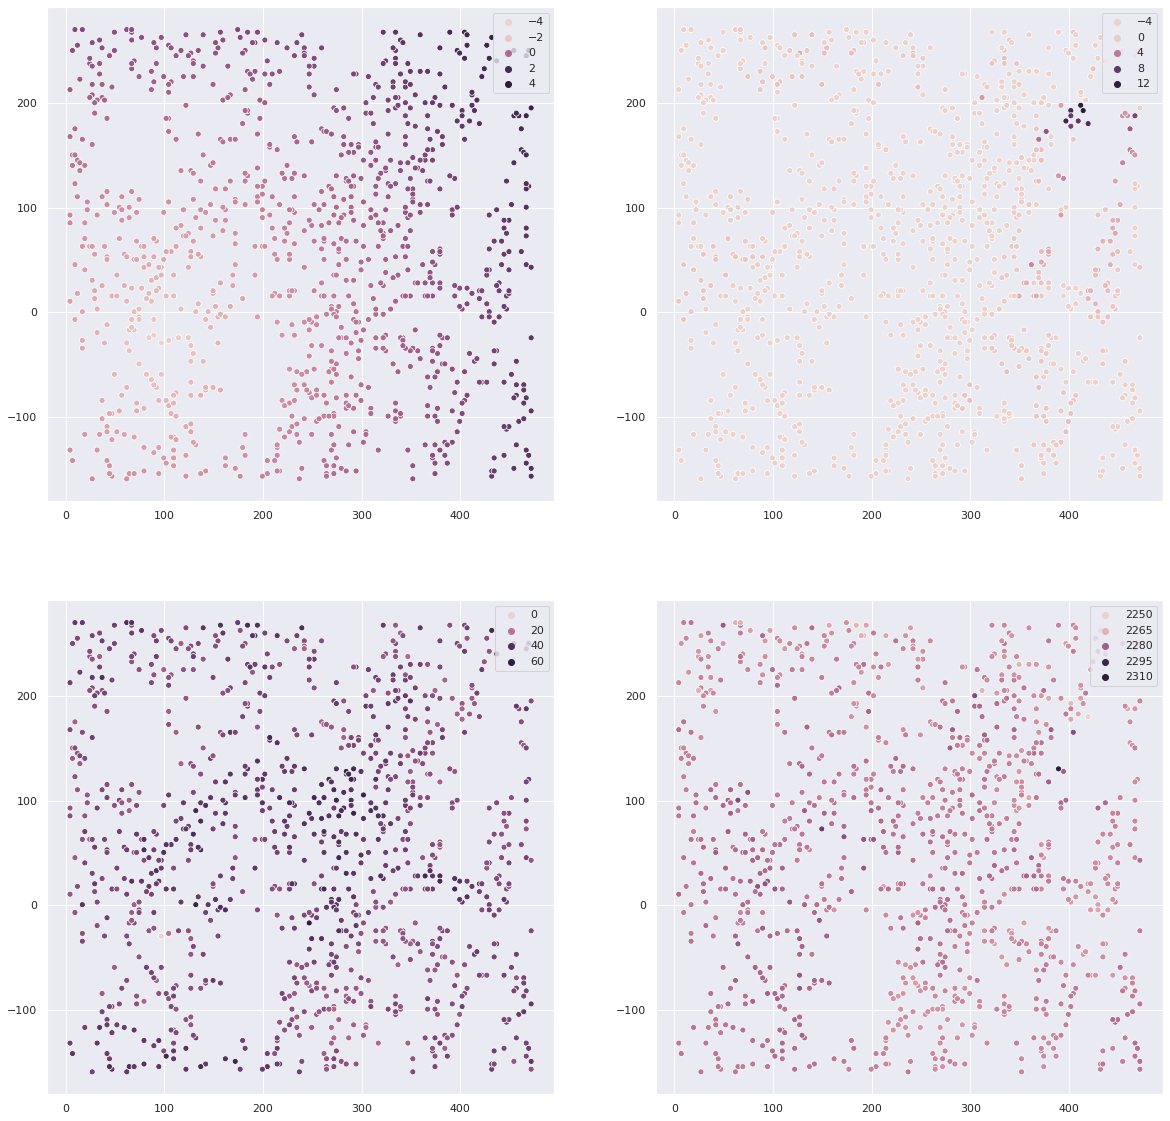

In [50]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
sns.scatterplot(positions_rx_undersample[:,0], positions_rx_undersample[:,1], hue=real_distance)
plt.subplot(2,2,2)
sns.scatterplot(positions_rx_undersample[:,0], positions_rx_undersample[:,1], hue=freq_distance_from_example)
plt.subplot(2,2,3)
sns.scatterplot(positions_rx_undersample[:,0], positions_rx_undersample[:,1], hue=phi_distance_from_example)
plt.subplot(2,2,4)
sns.scatterplot(positions_rx_undersample[:,0], positions_rx_undersample[:,1], hue=theta_distance_from_example)

In [51]:
import torch
phi_distance_matrix = distance_matrix(phi_scaled)
freq_distance_matrix = distance_matrix(data_fft_scaled)
theta_distance_matrix = distance_matrix(theta_scaled)

In [52]:
positions = positions_rx_undersample.reshape(*positions_rx_undersample.shape,1)
postions_distance_matrix = distance_matrix(positions)

In [53]:
phi_distances = phi_distance_matrix.flatten()
freq_distances = freq_distance_matrix.flatten()
theta_distances = theta_distance_matrix.flatten()
pos_distaces = postions_distance_matrix.flatten()

Text(0, 0.5, 'Paiwise phi distance')

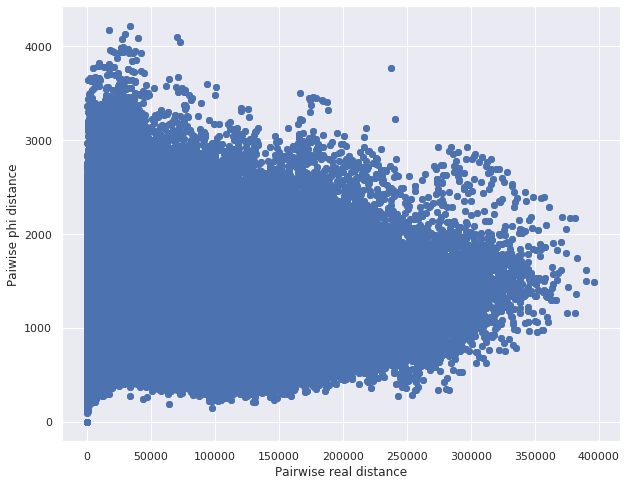

In [54]:
plt.scatter(pos_distaces, phi_distances)
plt.xlabel("Pairwise real distance")
plt.ylabel("Paiwise phi distance")

Text(0, 0.5, 'Paiwise theta distance')

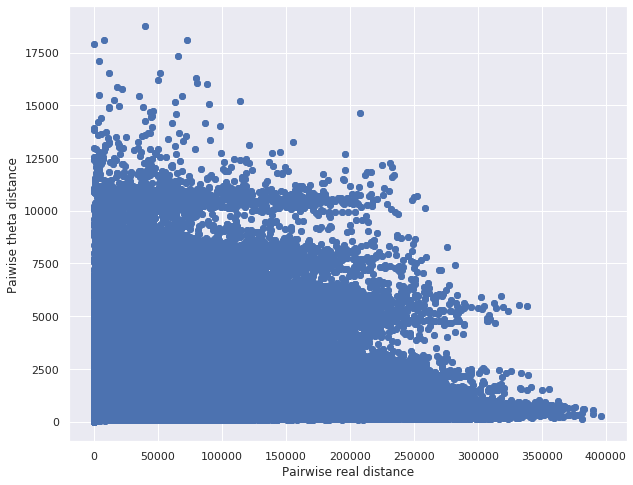

In [55]:
plt.scatter(pos_distaces, theta_distances)
plt.xlabel("Pairwise real distance")
plt.ylabel("Paiwise theta distance")

Text(0, 0.5, 'Paiwise freq distance')

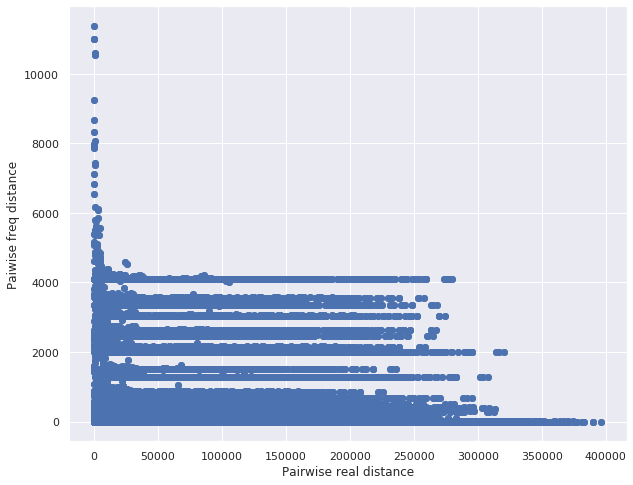

In [56]:
plt.scatter(pos_distaces, freq_distance_matrix)
plt.xlabel("Pairwise real distance")
plt.ylabel("Paiwise freq distance")